# Intent Analysis

## Introduction

## Importing Libraries & Zemberek & Other Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import re

In [2]:
import time
import logging

from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

In [3]:
# Zemberek'i kullanabillmek için ilk önce java kütüphenelerini kullanmamızı sağlayan kütüphaneyi ekleyelim
import jpype as jp

import warnings
warnings.filterwarnings("ignore")

In [4]:
import zipfile

def read_jar(jar_file):
    zf = zipfile.ZipFile(jar_file, 'r')
    try:
        lst = zf.infolist()
        for zi in lst:
            fn = zi.filename 
            # print(fn)
    finally:
        zf.close()
        
read_jar(r"zemberek-full.jar")

In [5]:
# Zembrek'i çalıştıralım
ZEMBEREK_PATH = r'zemberek-full.jar'
jp.startJVM(jp.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))

In [6]:
# Zemberekten gerekli modülleri import edelim
TurkishTokenizer = jp.JClass('zemberek.tokenization.TurkishTokenizer')
TurkishMorphology = jp.JClass('zemberek.morphology.TurkishMorphology')
TurkishSentenceExtractor = jp.JClass('zemberek.tokenization.TurkishSentenceExtractor')

morphology = TurkishMorphology.createWithDefaults()
tokenizer = TurkishTokenizer.ALL
extractor = TurkishSentenceExtractor.DEFAULT

I|20:25:42.689|Root lexicon created in 271 ms.                                                                     | DictionarySerializer#getDictionaryItems
I|20:25:42.689|Dictionary generated in 338 ms                                                                      | RootLexicon#defaultBinaryLexicon
I|20:25:42.898|Initialized in 550 ms.                                                                              | TurkishMorphology#createWithDefaults


### Adding Stopwords

In [7]:
# zemberekten aldığımız stopword dosyasını kullanarak bu kelimeleri metinlerden çıkartacağız
stopwords = [x.strip() for x in open(r'stop-words.txt','r', encoding="UTF8").read().split('\n')]
stopwords[30:50]

['adilane',
 'afedersin',
 'afedersinin',
 'aferin',
 'affettuoso',
 'agitato',
 'agucuk',
 'ağababa',
 'ağabey',
 'ağır',
 'ağızdan',
 'ah',
 'aha',
 'ahacık',
 'ahbap',
 'aheste',
 'ahir',
 'ahiren',
 'ahlaken',
 'ailecek']

### Importing & Adjusting Dataset

In [8]:
with open('intent_tr.json') as f:
    data = json.load(f)
df_ = data.copy()

In [9]:
df = pd.DataFrame(df_['intents'])
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Selamla,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...","[Merhaba, lütfen GeniSys kullanıcı adınızı söy...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'SelamlaKullanıcıSorgusu', '...",NA,[]
1,SelamlaYaniti,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",[Harika! Selamlar <KULLANICI>! Size nasıl yard...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'SelamlaKullaniciSorgusu', 'out': '', '...",NA,"[{'entity': 'KULLANICI', 'rangeFrom': 3, 'rang..."
2,NezaketSelami,"[Nasılsın?, Merhaba, nasılsın?, Selam, nasılsı...","[Merhaba, harikayım, sen nasılsın? Lütfen bana...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'NezaketSelamıKullanıcıSorgu...",NA,[]
3,NezaketSelamıYaniti,"[İyiyim teşekkür ederim! Ben Teknr!, Harikayım...",[Harika! Merhaba <KULLANICI>! Size nasıl yardı...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'NezaketSelamıKullanıcıSorgusu', 'out':...",NA,"[{'entity': 'KULLANICI', 'rangeFrom': 5, 'rang..."
4,MevcutInsanSorgusu,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",[Senin adın <HUMAN>! Sana nasıl yardımcı olabi...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [10]:
df_patterns = df[['text','intent']]
df_responses = df[['responses', 'intent']]
df_patterns

,text,intent
0,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...",Selamla
1,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",SelamlaYaniti
2,"[Nasılsın?, Merhaba, nasılsın?, Selam, nasılsı...",NezaketSelami
3,"[İyiyim teşekkür ederim! Ben Teknr!, Harikayım...",NezaketSelamıYaniti
4,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",MevcutInsanSorgusu
5,"[Adın ne?, Seni nasıl çağırabilirim?, Sana ne ...",Isim
6,"[Gerçek adın nedir?, Gerçek adını söyler misin...",GercekAdın
7,"[Saat kaç?, Saatin kaç olduğunu biliyor musun?...",SaatKac
8,"[Teşekkürler, Teşekkür ederim, Thx, Sağ ol, Sa...",Tesekkur
9,"[Seninle konuşmuyordum., Sana söylemedim., Sen...",SeninleKonusmuyorum


In [11]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Merhaba,Selamla
0,mrb,Selamla
0,meraba,Selamla
0,merb,Selamla
0,Selam,Selamla


## Explatory Data Analysis

In [12]:
# Displaying Information About Dataset
df_patterns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    165 non-null    object
 1   intent  165 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


In [13]:
df_patterns.describe().T

,count,unique,top,freq
text,165,164,İsmin ne?,2
intent,165,20,Selamla,41


In [14]:
# How Many Texts Are There?
df_patterns.text.count()

165

In [15]:
# How Many Intents Are There?
intent_counts = df_patterns.groupby("intent").size().reset_index(name="count")
intent_counts

,intent,count
0,Akilli,7
1,AnlandınMi,6
2,BenKimim,6
3,CourtesyGoodBye,6
4,Dedikodu,6
5,GercekAdın,7
6,GoodBye,10
7,Isim,6
8,KapaCeneni,7
9,KisiselFarkindalik,6


In [16]:
# Is There Any Null Value?
df_patterns.isnull().sum()

text      0
intent    0
dtype: int64

In [17]:
# Is There Any Duplicated Value?
df_patterns.duplicated().any()

False

In [18]:
df_patterns.text.is_unique

False

In [19]:
df_patterns[df_patterns.text.duplicated(keep=False)]

,text,intent
5,İsmin ne?,Isim
6,İsmin ne?,GercekAdın


In [20]:
df_patterns.drop_duplicates(subset='text', inplace=True)

In [21]:
df_patterns.describe().T

,count,unique,top,freq
text,164,164,Merhaba,1
intent,164,20,Selamla,41


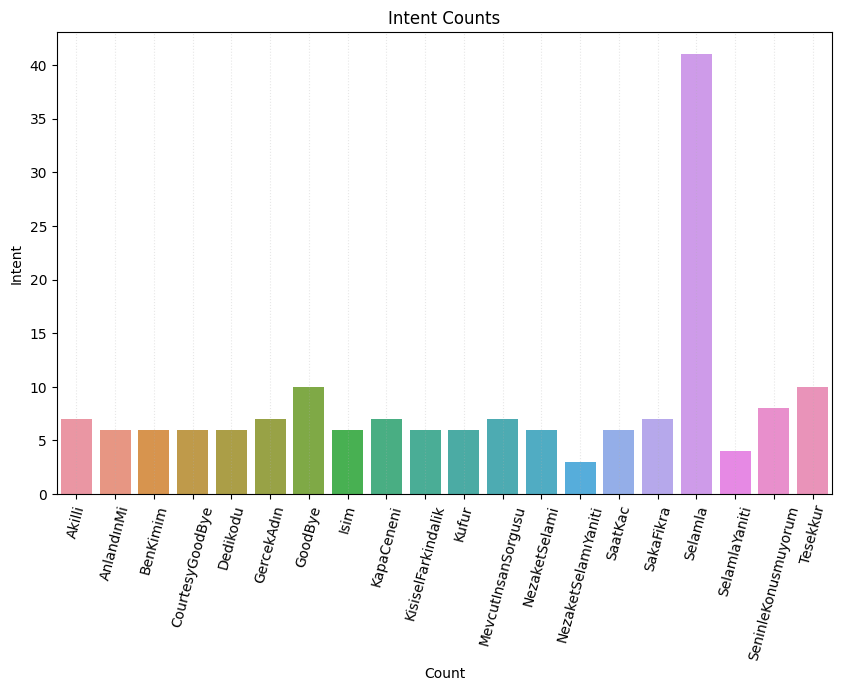

In [22]:
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
plt.xticks(rotation=75)
sns.barplot(x="intent", y="count", data=intent_counts, orient="v")
plt.title('Intent Counts')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.grid(axis='x', linestyle=':', alpha=0.3)

In [23]:
intent_counts["count"].median()

6.0

In [24]:
df_copy = df_patterns.copy()
df_copy.head()

,text,intent
0,Merhaba,Selamla
0,mrb,Selamla
0,meraba,Selamla
0,merb,Selamla
0,Selam,Selamla


## Data Pre-Processing

In [25]:
import data_preprocessing as prep

In [26]:
df_patterns['clean_text'] = df_patterns['text'].apply(lambda x : prep.data_cleaning(x))
df_patterns

,text,intent,clean_text
0,Merhaba,Selamla,merhaba
0,mrb,Selamla,mrb
0,meraba,Selamla,meraba
0,merb,Selamla,merb
0,Selam,Selamla,selam
...,...,...,...
19,Bilince sahip olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilince sahip olduğunu kanıtlayabilir misin
19,Bilinçli olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilinçli olduğunu kanıtlayabilir misin
19,Lütfen bilinçli olduğunu kanıtla.,KisiselFarkindalik,lütfen bilinçli olduğunu kanıtla
19,Bilince sahip olduğunu kanıtla.,KisiselFarkindalik,bilince sahip olduğunu kanıtla


In [40]:
df_patterns['clean_sw'] = df_patterns['text'].apply(lambda x: prep.remove_stopwords(x, stopwords))
df_patterns

,text,intent,clean_text,word_token,lemma_token,clean_sw
0,Merhaba,Selamla,merhaba,[merhaba],[merhaba],
0,mrb,Selamla,mrb,[mrb],[UNK],mrb
0,meraba,Selamla,meraba,[meraba],[meraba],meraba
0,merb,Selamla,merb,[merb],[UNK],merb
0,Selam,Selamla,selam,[selam],[selam],Selam
...,...,...,...,...,...,...
19,Bilince sahip olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilince sahip olduğunu kanıtlayabilir misin,"[bilince, sahip, olduğunu, kanıtlayabilir, misin]","[bil, sahip, ol, kanıtla, mi]",Bilince sahip olduğunu kanıtlayabilir misin?
19,Bilinçli olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilinçli olduğunu kanıtlayabilir misin,"[bilinçli, olduğunu, kanıtlayabilir, misin]","[bilinç, ol, kanıtla, mi]",Bilinçli olduğunu kanıtlayabilir misin?
19,Lütfen bilinçli olduğunu kanıtla.,KisiselFarkindalik,lütfen bilinçli olduğunu kanıtla,"[lütfen, bilinçli, olduğunu, kanıtla]","[lütfen, bilinç, ol, kanıt]",bilinçli olduğunu kanıtla.
19,Bilince sahip olduğunu kanıtla.,KisiselFarkindalik,bilince sahip olduğunu kanıtla,"[bilince, sahip, olduğunu, kanıtla]","[bil, sahip, ol, kanıt]",Bilince sahip olduğunu kanıtla.


In [47]:
df_patterns['clean_sw'][:10]

0           
0        mrb
0     meraba
0       merb
0      Selam
0        slm
0       slmz
0     selaam
0           
0    gnaydın
Name: clean_sw, dtype: object

In [27]:
df_patterns['word_token'] = df_patterns['clean_text'].apply(lambda x: prep.word_tokenize(x))
df_patterns

,text,intent,clean_text,word_token
0,Merhaba,Selamla,merhaba,[merhaba]
0,mrb,Selamla,mrb,[mrb]
0,meraba,Selamla,meraba,[meraba]
0,merb,Selamla,merb,[merb]
0,Selam,Selamla,selam,[selam]
...,...,...,...,...
19,Bilince sahip olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilince sahip olduğunu kanıtlayabilir misin,"[bilince, sahip, olduğunu, kanıtlayabilir, misin]"
19,Bilinçli olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilinçli olduğunu kanıtlayabilir misin,"[bilinçli, olduğunu, kanıtlayabilir, misin]"
19,Lütfen bilinçli olduğunu kanıtla.,KisiselFarkindalik,lütfen bilinçli olduğunu kanıtla,"[lütfen, bilinçli, olduğunu, kanıtla]"
19,Bilince sahip olduğunu kanıtla.,KisiselFarkindalik,bilince sahip olduğunu kanıtla,"[bilince, sahip, olduğunu, kanıtla]"


In [37]:
def lemmas(word_list):
    lemma = []
    for word in word_list:
        result = str(morphology.analyzeAndDisambiguate(word).bestAnalysis()[0].getLemmas()[0])
        if result == "UNK":
            lemma.append(result)
        else:
            lemma.append(result)
    return lemma

In [39]:
df_patterns['lemma_token'] = df_patterns['word_token'].apply(lambda x : lemmas(x))
df_patterns

,text,intent,clean_text,word_token,lemma_token
0,Merhaba,Selamla,merhaba,[merhaba],[merhaba]
0,mrb,Selamla,mrb,[mrb],[UNK]
0,meraba,Selamla,meraba,[meraba],[meraba]
0,merb,Selamla,merb,[merb],[UNK]
0,Selam,Selamla,selam,[selam],[selam]
...,...,...,...,...,...
19,Bilince sahip olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilince sahip olduğunu kanıtlayabilir misin,"[bilince, sahip, olduğunu, kanıtlayabilir, misin]","[bil, sahip, ol, kanıtla, mi]"
19,Bilinçli olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilinçli olduğunu kanıtlayabilir misin,"[bilinçli, olduğunu, kanıtlayabilir, misin]","[bilinç, ol, kanıtla, mi]"
19,Lütfen bilinçli olduğunu kanıtla.,KisiselFarkindalik,lütfen bilinçli olduğunu kanıtla,"[lütfen, bilinçli, olduğunu, kanıtla]","[lütfen, bilinç, ol, kanıt]"
19,Bilince sahip olduğunu kanıtla.,KisiselFarkindalik,bilince sahip olduğunu kanıtla,"[bilince, sahip, olduğunu, kanıtla]","[bil, sahip, ol, kanıt]"


In [49]:
!pip install torch

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [48]:
import torch
import random
import torch.nn as nn
import transformers
import gc
from transformers import BertTokenizer , BertModel
import matplotlib.pyplot as plt
device = torch.device('cuda')
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

In [29]:
df_a = prep.balance_data(df_patterns)
df_a

,text,intent,clean_text,word_token
0,Merhaba,Selamla,merhaba,[merhaba]
0,mrb,Selamla,mrb,[mrb]
0,meraba,Selamla,meraba,[meraba]
0,merb,Selamla,merb,[merb]
0,Selam,Selamla,selam,[selam]
...,...,...,...,...
30,Kendi farkındalığına sahip olduğunu kanıtlayab...,KisiselFarkindalik,kendi farkındalığına sahip olduğunu kanıtlayab...,"[kendi, farkındalığına, sahip, olduğunu, kanıt..."
31,Bilince sahip olduğunu kanıtlayabilir misin?,KisiselFarkindalik,bilince sahip olduğunu kanıtlayabilir misin,"[bilince, sahip, olduğunu, kanıtlayabilir, misin]"
32,Bilinçli olduğunu kanıtla.,KisiselFarkindalik,bilinçli olduğunu kanıtla,"[bilinçli, olduğunu, kanıtla]"
33,Kendi farkındalığına sahip olduğunu kanıtlayab...,KisiselFarkindalik,kendi farkındalığına sahip olduğunu kanıtlayab...,"[kendi, farkındalığına, sahip, olduğunu, kanıt..."


In [30]:
 df_a['intent'].value_counts()

intent
Selamla                41
SelamlaYaniti          41
SakaFikra              41
Dedikodu               41
Akilli                 41
BenKimim               41
CourtesyGoodBye        41
GoodBye                41
Kufur                  41
KapaCeneni             41
AnlandınMi             41
SeninleKonusmuyorum    41
Tesekkur               41
SaatKac                41
GercekAdın             41
Isim                   41
MevcutInsanSorgusu     41
NezaketSelamıYaniti    41
NezaketSelami          41
KisiselFarkindalik     41
Name: count, dtype: int64